In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")



In [7]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/9g/tnv_kfvn5kx8s1x4rjvf1gmr0000gn/T/ipykernel_15229/3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': '### **Meta Platforms Overhauls Content Moderation Policies**\n\n**Date:** March 3, 2025\n\n**Summary:** **Meta**, led by CEO **Mark Zuckerberg**, has implemented significant policy changes, including replacing third-party fact-checking with **community notes** and relaxing hate speech policies. These changes aim to promote open discussions but have sparked criticism from various communities. [...] **Date:** March 5, 2025\n\n**Summary:** **Andrew Barto** and **Richard Sutton**, known for their groundbreaking work in **reinforcement learning**, have been awarded the prestigious **2025 Turing Award**. Their contributions have shaped modern AI techniques used in robotics, game theory, and autonomous systems.\n\n**Source:** [The New York Times](https://www.nytimes.com/2025/03/05/technology/turing-award-andrew-barto-richard-sutton.htm

In [9]:
### Combine all the tools in the list

tools = [arxiv, wiki, tavily, check_retraction]

In [10]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen-qwq-32b")

llm_with_tools=llm.bind_tools(tools)

In [11]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let\'s look at the available functions. There\'s arxiv, which is for academic papers, wikipedia for encyclopedic info, and tavily_search_results_json, which sounds like a general web search. Since they want recent news, Wikipedia might not be the best because it\'s not real-time. Arxiv is more for research papers, which might not cover the latest news. The Tavily search function seems the most suitable because it can provide current search results. I\'ll go with Tavily and use the query "latest AI news" to get the most recent information.\n', 'tool_calls': [{'id': 'mscv0dwwh', 'function': {'arguments': '{"query":"latest AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 169, 'prompt_tokens': 268, 'total_tokens': 437, 'completion_time': 0.413821062, 'prompt_t

In [12]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest AI news'},
  'id': 'mvwtj9qd3',
  'type': 'tool_call'}]

In [13]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

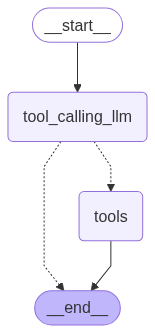

In [14]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [15]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (8gzv6kzkz)
 Call ID: 8gzv6kzkz
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [16]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (e9cvgvc6q)
 Call ID: e9cvgvc6q
  Args:
    query: top 10 recent AI news March 3rd 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI Pulse News Roundup (March 2025 Edition) - Community", "url": "https://community.openai.com/t/ai-pulse-news-roundup-march-2025-edition/1132414", "content": "Newsguard tested ten leading AI services, including OpenAI's ChatGPT, xAI's Grok, Google's Gemini, Microsoft's Copilot, and Anthropic's Claude.", "score": 0.8889231}, {"title": "Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "### **Meta Platforms Overhauls Content Moder

In [17]:
messages=graph.invoke({"messages":HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (v61m1hnba)
 Call ID: v61m1hnba
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi


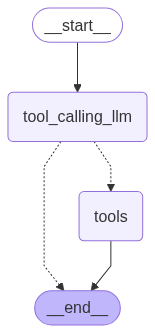

In [18]:
# --- Imports ---
import os
from dotenv import load_dotenv

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_groq import ChatGroq

from langchain_core.messages import HumanMessage, AnyMessage
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

from IPython.display import Image, display

# --- Load environment variables ---
load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

import requests
from langchain_core.tools import tool

@tool
def check_retraction(paper_title: str) -> str:
    """Checks Crossref to see if a paper with the given title has been retracted."""
    print(f"Querying Crossref for retraction info on: {paper_title}")
    try:
        url = "https://api.crossref.org/works"
        params = {
            "query.title": paper_title,
            "filter": "relation.type:retracted-by",
            "rows": 5
        }
        response = requests.get(url, params=params, timeout=10)
        data = response.json()

        # Check if any items were returned with retraction relation
        items = data.get("message", {}).get("items", [])

        if not items:
            return f"The paper '{paper_title}' is not listed as retracted in Crossref."

        # Extract and show retraction info
        retracted_titles = [item.get("title", ["Unknown"])[0] for item in items]
        return f"The paper '{paper_title}' **has been retracted**. Related title(s) found: {', '.join(retracted_titles)}"

    except Exception as e:
        return f"Error checking retraction status: {str(e)}"


# --- Initialize tools ---
arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500))
wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500))
tavily = TavilySearchResults()

tools = [arxiv, wiki, tavily, check_retraction]

# --- LLM setup ---
llm = ChatGroq(model="qwen-qwq-32b")
llm_with_tools = llm.bind_tools(tools)

# --- LangGraph state ---
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# --- Build LangGraph ---
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
query = "Check if the paper 'AI based vision inspection for manufacturing industries' has been retracted"

response = graph.invoke({"messages": [HumanMessage(content=query)]})

# Print assistant message if it exists
assistant_message = None
tool_outputs = []

for m in response["messages"]:
    if m.type == "ai":
        assistant_message = getattr(m, "content", "").strip()

        # Collect tool call names
        if hasattr(m, "tool_calls") and m.tool_calls:
            for call in m.tool_calls:
                tool_outputs.append(call["name"])

# Print assistant message or fallback to tool output
if assistant_message:
    print("Assistant:", assistant_message)
else:
    print("Assistant did not return a message directly.")

# Print tool usage
if tool_outputs:
    print("Tools used:")
    for tool in tool_outputs:
        print("-", tool)

# OPTIONAL: Extract the actual tool output from the last message (if available)
# ToolNode automatically appends the result as a new message
for m in response["messages"]:
    if m.type == "tool":
        print("Tool result:", m.content)


Checking retraction database for: AI based vision inspection for manufacturing industries
Assistant did not return a message directly.
Tools used:
- check_retraction
Tool result: The paper 'AI based vision inspection for manufacturing industries' is not listed as retracted.
